## Imports

In [1]:
import os
import sys
import argparse

import scanpy as sc
import pickle as pkl
import pandas as pd
from scipy.sparse import csr_matrix, find
import numpy as np
from sklearn.preprocessing import minmax_scale
from scipy.stats import entropy
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import normalized_mutual_info_score

import gc

from matplotlib.pyplot import rcParams
import matplotlib.pyplot as plt
import seaborn as sb

In [2]:
import torch
from cross_system_integration.model._xxjointmodel import XXJointModel
from pytorch_lightning.callbacks.base import Callback

Global seed set to 0


## Config

In [3]:
SYSTEM_KEY = 'system'
BATCH_KEYS = ['batch']
CT_KEY = 'cell_type_eval'

In [4]:
path_data = os.path.expanduser("~/data/cs_integration/combined_orthologuesHVG.h5ad")
path_fig = os.path.expanduser(f"~/io/cs_integration/figures/")

RUNS_TO_LOAD = {
    #'2_prior_system_0': os.path.expanduser('~/io/cs_integration/vamp_testing_pancreas_combined_orthologuesHVG_n_prior_2_trainable_prior_True_init_system_0/'),
    '2_prior_balanced': os.path.expanduser('~/io/cs_integration/vamp_testing_pancreas_combined_orthologuesHVG_n_prior_2_trainable_prior_True_init_most_balanced/'),
   # '2_prior_system_1': os.path.expanduser('~/io/cs_integration/vamp_testing_pancreas_combined_orthologuesHVG_n_prior_2_trainable_prior_True_init_system_1/'),
   # '4_prior_balanced': os.path.expanduser('~/io/cs_integration/vamp_testing_pancreas_combined_orthologuesHVG_n_prior_4_trainable_prior_True_init_most_balanced/'),
    #'10_prior_balanced': os.path.expanduser('~/io/cs_integration/vamp_testing_pancreas_combined_orthologuesHVG_n_prior_10_trainable_prior_True_init_most_balanced/'),
}

n_prior_n_ct_runs = os.path.expanduser('~/io/cs_integration/vamp_balanced_testing_pancreas_combined_orthologuesHVG_n_prior_{n_prior}_trainable_prior_True_init_system_0_nct_{n_ct}/')
n_prior_init_method_runs = os.path.expanduser('~/io/cs_integration/vamp_testing_pancreas_combined_orthologuesHVG_n_prior_{n_prior}_trainable_prior_True_init_{init_method}/')
sc.settings.figdir = os.path.expanduser(f"~/io/cs_integration/figures/")

In [5]:
SYSTEM_MAP = {'0': 'Mouse', '1': 'Human', '0.0': 'Mouse', '1.0': 'Human'}

## Load pancreas data

In [6]:
adata=sc.read(path_data)
adata

AnnData object with n_obs × n_vars = 455343 × 1768
    obs: 'batch', 'mm_study', 'mm_sex', 'mm_age', 'mm_study_sample_design', 'mm_hc_gene_programs_parsed', 'mm_leiden_r1.5_parsed', 'cell_type_eval', 'system', 'hs_Sex', 'hs_Diabetes Status'
    var: 'gs_mm', 'gs_hs'
    layers: 'counts'

In [7]:
with open(os.path.expanduser('~/io/cs_integration/colors/obs_col_cmap.pkl'), 'rb') as f:
    obs_cmap = pkl.load(f)

## Prior update over time

In [8]:
# Load data
run = '2_prior_balanced'
adata_training = adata.copy()
model = XXJointModel.load(RUNS_TO_LOAD[run], adata=adata_training)
embed_all = sc.read(os.path.join(RUNS_TO_LOAD[run], 'embed_all.h5ad'))
embed_all.obs['system'] = embed_all.obs['system'].astype(str).map(SYSTEM_MAP).astype(str).replace('nan', float('nan'))
sample_frac = 1.
if sample_frac < 1.:
    cells = embed_all[embed_all.obs['pseudoinput_id'].isna()].copy()
    pis = embed_all[~embed_all.obs['pseudoinput_id'].isna()].copy()
    sc.pp.subsample(cells, fraction=sample_frac)
    embed_all = sc.concat([cells, pis])
embed_all

INFO     File                                                                                                      
         /dss/dsshome1/03/di93zoz/io/cs_integration/vamp_testing_pancreas_combined_orthologuesHVG_n_prior_2_trainab
         le_prior_True_init_most_balanced/model.pt already downloaded                                              


AnnData object with n_obs × n_vars = 455445 × 15
    obs: 'batch', 'mm_study', 'mm_sex', 'mm_age', 'mm_study_sample_design', 'mm_hc_gene_programs_parsed', 'mm_leiden_r1.5_parsed', 'cell_type_eval', 'system', 'hs_Sex', 'hs_Diabetes Status', 'species', 'most_probable_prior_p', 'most_probable_prior_id', 'input_type', 'pseudoinput_id', 'pseudoinput_time'
    uns: 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'prior_probs'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [9]:
mapping = {
    'beta': 'Beta',
    'endothelial': 'Endothelial',
    'acinar': 'Acinar',
    'alpha': 'Alpha',
    'delta': 'Delta',
    'gamma': 'Gamma',
    'immune': 'Immune',
    'stellate a.': 'Stellate a.',
    'ductal': 'Ductal',
    'alpha+beta': 'Alpha+Beta',
    'stellate q.': 'Stellate q.',
    'beta+gamma': 'Beta+Gamma',
    'beta+delta': 'Beta+Delta',
    'schwann': 'Schwann',
    'endo. prolif.': 'Endo. prolif.',
    'alpha+delta': 'Alpha+Delta',
    'delta+gamma': 'Delta+Gamma',
}
embed_all.obs["cell_type_new"] = embed_all.obs[CT_KEY].map(mapping)
obs_cmap['pancreas']["cell_type_new"] = dict(zip(
    list(map(lambda x: mapping[x], list(obs_cmap['pancreas'][CT_KEY].keys()))), 
    obs_cmap['pancreas'][CT_KEY].values()
))

/dss/dsshome1/03/di93zoz/miniconda3/envs/csi/lib/python3.10/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/dss/dsshome1/03/di93zoz/miniconda3/envs/csi/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(
/dss/dsshome1/03/di93zoz/miniconda3/envs/csi/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/dss/dsshome1/03/di93zoz/miniconda3/envs/csi/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/dss/dsshome1/03/di93zoz/miniconda3/envs/csi/lib/python3.10/site-packages/scanpy/plotting/_tools/

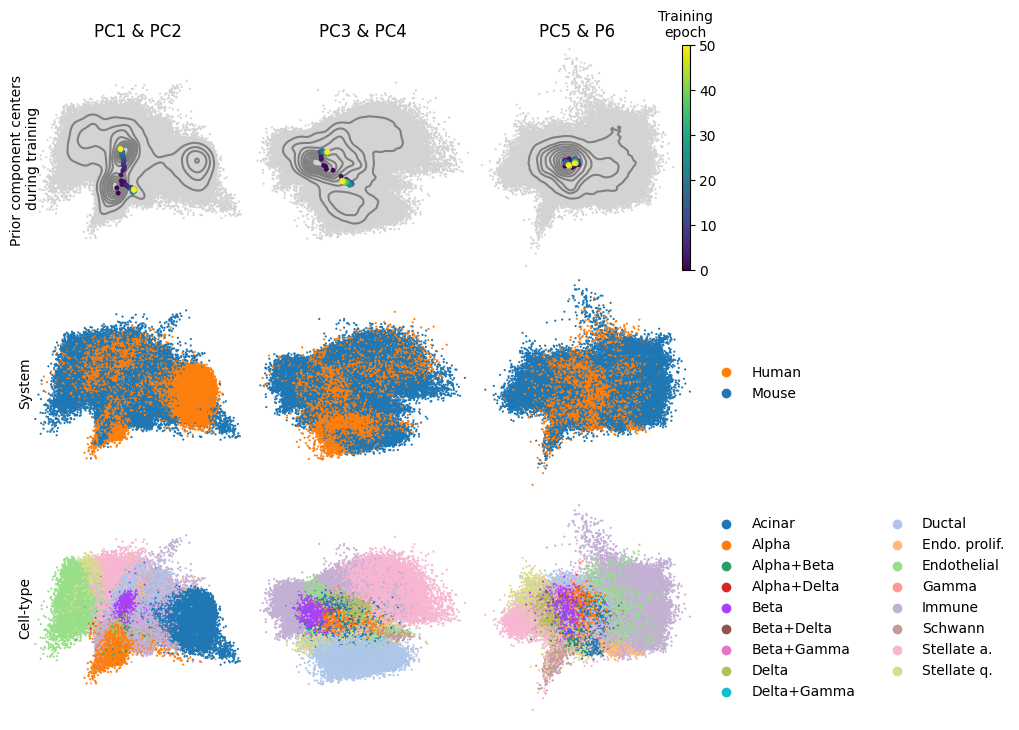

In [10]:
# plot prior component movement during training
size = 5
fig,axs=plt.subplots(3, 3,figsize=(1.5*size, 1.5*size),
                     sharey='row')
for i, (components, title) in enumerate(zip(
    ['1,2'
     , '3,4', '5,6'
    ],
    ['PC1 & PC2', 
     'PC3 & PC4', 'PC5 & P6'
    ],
)):
    for j, col in enumerate(['pseudoinput_time', 'system', "cell_type_new"]):
        ax = axs[j, i]
        if col == 'pseudoinput_time':
            if components == '1,2':
                embed_all.obsm['X_pca_sub'] = embed_all.obsm['X_pca'][:, 0:2]
            if components == '3,4':
                embed_all.obsm['X_pca_sub'] = embed_all.obsm['X_pca'][:, 2:4]
            if components == '5,6':
                embed_all.obsm['X_pca_sub'] = embed_all.obsm['X_pca'][:, 4:6]
            df = pd.DataFrame(embed_all.obsm['X_pca_sub'], columns=['x', 'y'])
            embed_all.obs['dummy'] = float('nan')
            sc.pl.pca(embed_all[embed_all.obs['pseudoinput_time'].isna()], alpha=1., colorbar_loc=None if i != 2 else 'right',
                      size=10, components=components, ax=ax, show=False, frameon=False, title='', legend_loc='none', zorder=0)
            plot = sb.kdeplot(data=df, x="x", y="y", ax=ax, zorder=5, color='gray')
        if col == 'pseudoinput_time':
            cmap = None
        else:
            cmap = obs_cmap['pancreas'][col]
            if col == 'system':
                cmap = {SYSTEM_MAP[k]: v for k, v in cmap.items()}
        sc.pl.pca(embed_all if col != 'pseudoinput_time' else embed_all[~embed_all.obs['pseudoinput_time'].isna()], na_in_legend=False, colorbar_loc=None if i != 2 else 'right',
                  color=col, size=50 if j == 0 else 10, components=components, ax=ax, show=False, palette=cmap, frameon=False, title='' if j != 0 else title, legend_loc='none' if i != 2 else 'right margin', zorder=10)
        
        if i == 2:
            cmaps=[a for a in fig.axes if a.get_label()=='<colorbar>']
            cmap=cmaps[-1]
            if j == 0:
                cmap.set_title('Training\nepoch',fontsize=10)
        # if i == 2:
        #     if j == 0:
        #         ax.annotate("Training epoch", zorder=100,
        #                     xy=(1.5,0.2), xytext=(1.5, 0.0), textcoords='axes fraction', va='center', ha='center')
        if i == 0:
            pos = (0, 0.5)
            if j == 0:
                ax.annotate("Prior component centers \nduring training", zorder=100,
                            xy=pos, xytext=pos, textcoords='axes fraction', rotation='vertical', va='center', ha='center')
            if j == 1:
                ax.annotate("System", zorder=100,
                            xy=pos, xytext=pos, textcoords='axes fraction', rotation='vertical', va='center', ha='center')
            if j == 2:
                ax.annotate("Cell-type", zorder=100,
                            xy=pos, xytext=pos, textcoords='axes fraction', rotation='vertical', va='center', ha='center')

plt.subplots_adjust(left=0.05,
                    bottom=0.05,
                    right=0.95,
                    top=0.95,
                    wspace=0.0,
                    hspace=0.0)
plt.savefig(path_fig+f'pi_movement.pdf', dpi=300, bbox_inches='tight')
plt.savefig(path_fig+f'pi_movement.png', dpi=300, bbox_inches='tight')

## Most probable prior component

In [11]:
mapping = {
    'beta': 'Beta',
    'endothelial': 'Endothelial',
    'acinar': 'Acinar',
    'alpha': 'Alpha',
    'delta': 'Delta',
    'gamma': 'Gamma',
    'immune': 'Immune',
    'stellate a.': 'Stellate a.',
    'ductal': 'Ductal',
    'alpha+beta': 'Alpha+Beta',
    'stellate q.': 'Stellate q.',
    'beta+gamma': 'Beta+Gamma',
    'beta+delta': 'Beta+Delta',
    'schwann': 'Schwann',
    'endo. prolif.': 'Endo. prolif.',
    'alpha+delta': 'Alpha+Delta',
    'delta+gamma': 'Delta+Gamma',
}
obs_cmap['pancreas']["cell_type_new"] = dict(zip(
    list(map(lambda x: mapping[x], list(obs_cmap['pancreas'][CT_KEY].keys()))), 
    obs_cmap['pancreas'][CT_KEY].values()
))

In [13]:
def average_class_entropy(classes, clusters, eps=1e-10):
    df = pd.DataFrame({'class': classes, 'cluster': clusters})
    n_clusters = len(df['cluster'].unique().to_list())
    df = df.assign(count=1).groupby(['class', 'cluster']).agg({'count': 'sum'}).reset_index()
    df['total_count'] = df.groupby('class')['count'].transform('sum')
    df['p'] = df['count'] / df['total_count']
    df['ent'] = - df['p'] * np.log2(df['p'] + eps)
    df = df.groupby('class').agg({'ent': 'sum', 'total_count': 'max'}).reset_index()
    df['ent'] /= np.log2(n_clusters)
    avg_ent = np.sum((df['ent'] * df['total_count']).values) / np.sum(df['total_count'].values)
    return avg_ent, df[['class', 'ent']]

In [14]:
cb_cmap = {
    0: '#648FFF',
    1: '#785EF0',
    2: '#DC267F',
    3: '#FE6100',
    4: '#FFB000',
}

In [15]:
# Max possible entropy with 5 classes
-np.log2(1/5)

2.321928094887362

/dss/dsshome1/03/di93zoz/miniconda3/envs/csi/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/dss/dsshome1/03/di93zoz/miniconda3/envs/csi/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/dss/dsshome1/03/di93zoz/miniconda3/envs/csi/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/dss/dsshome1/03/di93zoz/miniconda3/envs/csi/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/dss/dsshome1/03/di93zoz/miniconda3/envs/csi/lib/python3.10/site-packages/scanpy/plotting/_tools/sca

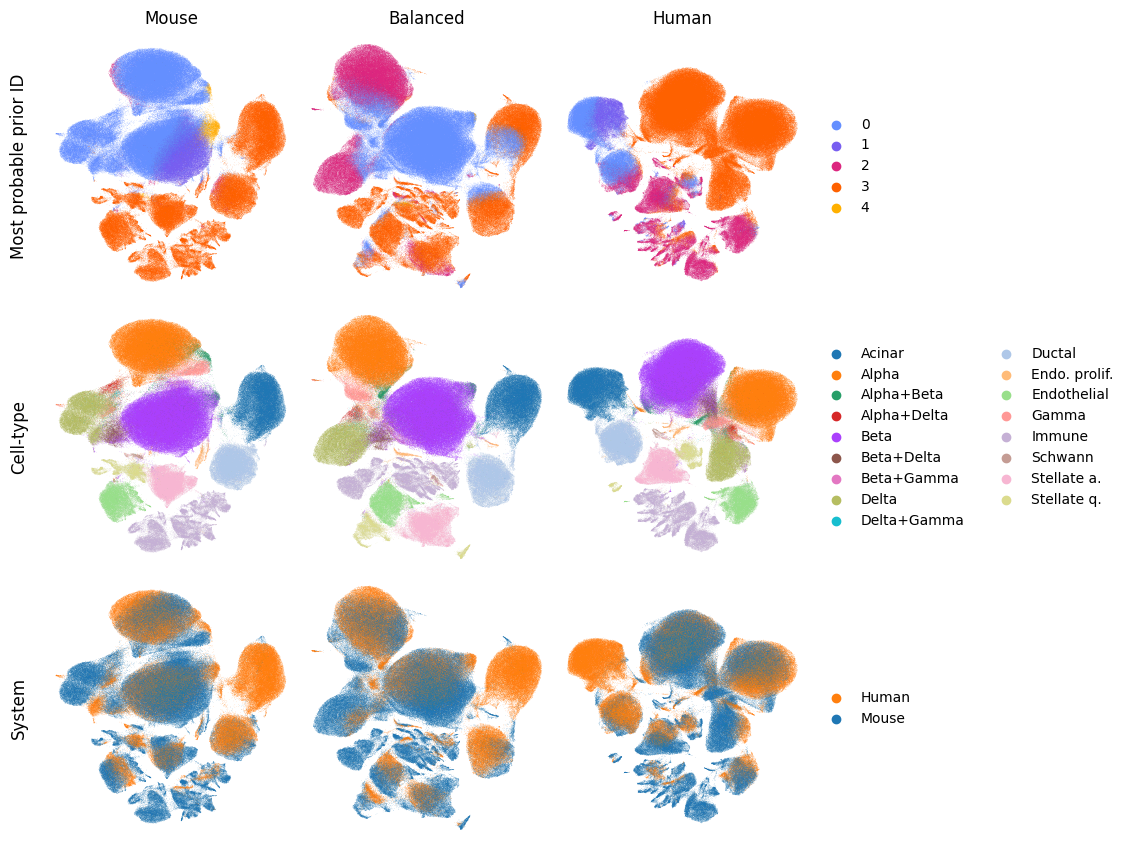

In [16]:
# Plot most probable prior per cell
size = 3
n_prior_list = [
    5,
    # 20,
]
fig,axs=plt.subplots(3 * len(n_prior_list), 3,figsize=(3 * size, 3 * len(n_prior_list)*size),
                     sharey='row')
# for j, n_prior in enumerate([1,2, 4,10]):
#     for offset, plot_type in enumerate(['Most probable prior ID', 'cell-type', 'system']):
#         ax = axs[3*j + offset, 0]
#         ax.text(0,0, f"{plot_type}\nn prior: {n_prior}")
#         ax.axis('off')

avents = []
    
for i, (init_method, init_method_text) in enumerate(zip([
    'system_0', 'most_balanced', 'system_1'
], ['Mouse', 'Balanced', 'Human'])):
    for j, n_prior in enumerate(n_prior_list):
        pos = (-0.1, 0.5)
        embed = sc.read(os.path.join(n_prior_init_method_runs.format(n_prior=n_prior, init_method=init_method), 'embed.h5ad'))
        embed.obs['cell_type_new'] = embed.obs[CT_KEY].map(mapping)
        ax = axs[3*j, i]
        sc.pl.umap(embed, color='most_probable_prior_id', 
                   palette=cb_cmap, 
                   # cmap='tab20',
                   ax=ax, show=False, frameon=False, title='' if j != 0 else f"{init_method_text}", legend_loc='none' if i != 2 else 'right margin')
        if i == 0:
            ax.annotate("Most probable prior ID", zorder=100, fontsize=12,
                        xy=pos, xytext=pos, textcoords='axes fraction', rotation='vertical', va='center', ha='center')
        
        ax = axs[3*j+1, i]
        cmap = obs_cmap['pancreas']["cell_type_new"]
        # nmi = normalized_mutual_info_score(embed.obs["cell_type_new"].values, embed.obs['most_probable_prior_id'].values)
        # nmi = ((nmi * 100) // 1) / 100
        # ax.annotate(f"nmi: {nmi}", xy=(1, 0), xycoords='axes fraction', fontsize=16, horizontalalignment='right', verticalalignment='bottom')
        avent, avent_df = average_class_entropy(embed.obs["cell_type_new"].values, embed.obs['most_probable_prior_id'].values)
        # avent = ((avent * 1000) // 1) / 1000
        # ax.annotate(f"E[H(prior_id)]:\n{avent}", xy=(0.0, 0.1), xycoords='axes fraction', fontsize=10, horizontalalignment='left', verticalalignment='bottom')
        avents.append(avent_df.reset_index().assign(c="cell_type", init=init_method_text, n_prior=n_prior))
        sc.pl.umap(embed, color="cell_type_new", ax=ax, show=False, palette=cmap, frameon=False, title='', legend_loc='none' if i != 2 else 'right margin')
        if i == 0:
            ax.annotate("Cell-type", zorder=100, fontsize=12,
                        xy=pos, xytext=pos, textcoords='axes fraction', rotation='vertical', va='center', ha='center')

        ax = axs[3*j+2, i]
        cmap = obs_cmap['pancreas']['system']
        embed.obs['system'] = embed.obs['system'].astype(str).map(SYSTEM_MAP).astype(str)
        cmap = {SYSTEM_MAP[k]: v for k, v in cmap.items()}
        # nmi = normalized_mutual_info_score(embed.obs['system'].values, embed.obs['most_probable_prior_id'].values)
        # nmi = ((nmi * 100) // 1) / 100
        # ax.annotate(f"nmi: {nmi}", xy=(1, 0), xycoords='axes fraction', fontsize=16, horizontalalignment='right', verticalalignment='bottom')
        avent, avent_df = average_class_entropy(embed.obs['system'].values, embed.obs['most_probable_prior_id'].values)
        # avent = ((avent * 1000) // 1) / 1000
        # ax.annotate(f"E[H(prior_id)]:\n{avent}", xy=(0.0, 0.1), xycoords='axes fraction', fontsize=10, horizontalalignment='left', verticalalignment='bottom')
        avents.append(avent_df.reset_index().assign(c="system", init=init_method_text, n_prior=n_prior))
        sc.pl.umap(embed, color='system', ax=ax, show=False, palette=cmap, frameon=False, title='', legend_loc='none' if i != 2 else 'right margin')
        if i == 0:
            ax.annotate("System", zorder=100, fontsize=12,
                        xy=pos, xytext=pos, textcoords='axes fraction', rotation='vertical', va='center', ha='center')


plt.subplots_adjust(left=0.1,
                    bottom=0.05,
                    right=0.95,
                    top=0.95,
                    wspace=0.01,
                    hspace=0.01)
plt.savefig(path_fig+f'n_prior_init_most_probable_prior.pdf', dpi=300, bbox_inches='tight')
plt.savefig(path_fig+f'n_prior_init_most_probable_prior.png', dpi=300, bbox_inches='tight')
plt.show()

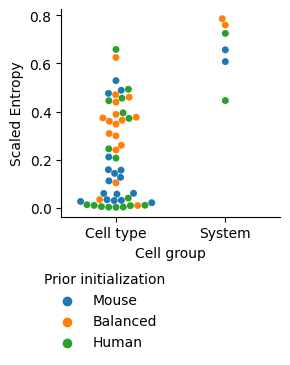

In [25]:
# Prior cassignmnet entropy per cell group
plt.figure(figsize=(3,5))
ax = sb.swarmplot((
        pd.concat(avents)
        .rename(columns={'ent': 'Scaled Entropy', 'c': 'Cell group', 'init': 'Initialization Method'})
        .replace("system", "System")
        .replace("cell_type", "Cell type")
    )
    , 
    y='Scaled Entropy', x='Cell group', hue='Initialization Method')
sb.move_legend(ax, "lower center", bbox_to_anchor=(.2, -0.7), ncol=1, title='Prior initialization', frameon=False)
sb.despine(top=True, right=True)
fig = ax.get_figure()
fig.tight_layout()
fig.savefig(path_fig+f'most_probable_prior_entropy_swarm_plot.pdf') 
fig.savefig(path_fig+f'most_probable_prior_entropy_swarm_plot.png') 
plt.show()